<center><h1>A Comprehensive Analysis of Convolutional Neural Networks</h1>
<h2>Matthias Bartolo</h2>

</center>

# Convolutional Neural Network (CNN)

This assignment is an _edited_ version of Tensorflow's official [CNN tutorial](https://www.tensorflow.org/tutorials/images/cnn). The goal of this assignment is to go through the notebook and fill in the empty code cells when prompted. Moreover, you will be asked to write down short comments on any notable observations in the _Comments_ section under each question.

As a precursor to starting this assignment, you can optionally go through the original notebook and read through any extra comments that might have been removed in this version.

This notebook can be run locally, or can be run from <b>Google Colab</b> which can be found [here](https://colab.research.google.com/drive/1PztXT1Xe7AMkNpy-O4tUAkn2wDfeI41H?usp=sharing).

### Import TensorFlow

<font size="0.7">

```python
conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# Anything above 2.10 is not supported on the GPU on Windows Native
python -m pip install "tensorflow<2.11"
# Verify the installation:
python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"
```

</font>

In [1]:
from time import time
import tensorflow as tf
import numpy as np
import seaborn as sns

import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

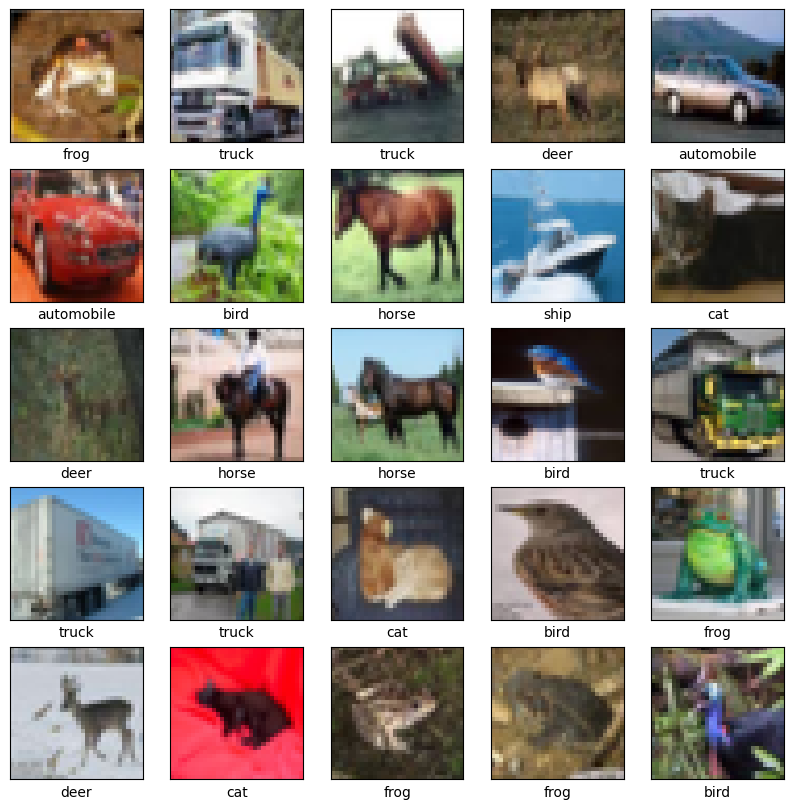

In [2]:
# Loading and splitting the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalizing pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Declaring the class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plotting the first 25 images from the training set and displaying the class name below each image
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Creating the model's architecture

In [3]:
def fit(model, epochs:int=100, optimizer=Adam(clipnorm=1.0), verbose:int=1, batch_size:int=256, callbacks=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), colors:tuple=('blue','purple','green','cyan'), do_display:bool=False, do_save:bool=False, save_name:str='model'):
    """Function which fits a model to the training data and plots the training process.

    Args:
        model (keras.model): Model to fit
        epochs (int, optional): Number of epochs to train for. Defaults to 10.
        optimizer (str, optional): Optimizer to use. Defaults to 'adam'.
        verbose (int, optional): Verbosity of training. Defaults to 1.
        batch_size (int, optional): Batch size. Defaults to 32.
        callbacks (list, optional): List of callbacks. Defaults to [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)].
        colors (tuple, optional): Colors to use for plotting. Defaults to ('blue','purple','green','cyan').`
        do_save (bool, optional): Whether to save the model. Defaults to False.
        save_name (str, optional): Name of the model to save. Defaults to 'model'.
    """

    # Loading the model
    model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

    # Printing the model summary
    print(model.summary())

    # Setting the start time
    s=time()

    # Training Model
    history = model.fit(train_images, train_labels, epochs=epochs, verbose=verbose,
                        validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=callbacks)

    # Printing the training time
    print(f'\033[36mTraining Time: {round(time()-s,2)}s\033[0m')
    print('*'*50)

    # Plotting Training process
    plt.plot(history.history['accuracy'], label='Train Accuracy', color = colors[0])
    plt.plot(history.history['loss'], label = 'Train Loss', color = colors[1], linestyle='dashed')
    plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = colors[2])
    plt.plot(history.history['val_loss'], label = 'Validation Loss', color = colors[3], linestyle='dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Testing the model
    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

    # Calculating the Precision, Recall and F1 Score
    y_pred = model.predict(test_images)
    y_pred = [np.argmax(i) for i in y_pred]
    
    # Printing the test results
    print(f'\033[35mTest Accuracy: {round(test_acc,2)}\033[0m')
    print(f'\033[34mTest Loss: {round(test_loss,2)}\033[0m')
    print(f'\033[33mTest Precision: {round(precision_score(test_labels, y_pred, average="weighted"),2)}\033[0m')
    print(f'\033[32mTest Recall: {round(recall_score(test_labels, y_pred, average="weighted"),2)}\033[0m')
    print(f'\033[31mTest F1 Score: {round(f1_score(test_labels, y_pred, average="weighted"),2)}\033[0m')

    # Plotting the confusion matrix
    if do_display:
        cm = confusion_matrix(test_labels, y_pred)
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

    # Saving the model
    if do_save:
        model.save(f'{save_name}.h5')

    return test_acc

In the original notebook, the below model configuration was used. 3 Convolution Layers were used to extract visual features from the image. Then these features are passed to a normal Neural Network which will learn to classify the different class labels.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 1024)             

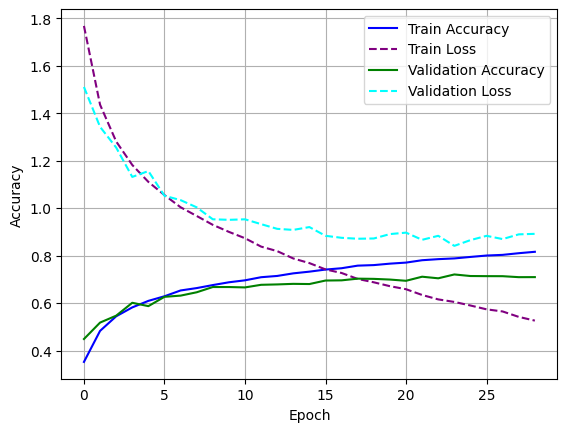

313/313 - 0s - loss: 0.8409 - accuracy: 0.7204 - 363ms/epoch - 1ms/step
313/313 [==============================] - 0s 756us/step
Test Accuracy: 0.72
Test Loss: 0.84
Test Precision: 0.72
Test Recall: 0.72
Test F1 Score: 0.72


In [6]:
# Creating the model
model = models.Sequential()

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
# These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Adding Dense/Fully-Connected Layers.
# These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# Fitting the model
fit(model,verbose=0)
del model

### Q.1
Create a model architecture that has only one (Conv2D+MaxPooling2D) layer. Then. pass this model to the predefined <code>fit</code> function, which will train the model, display the training progress, and evaluate on the test set.  

Write down what differences you note between this model and the original one in the _Comments_ section.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 7200)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                460864    
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 462,410
Trainable params: 462,410
Non-trainable params: 0
________________________________________________

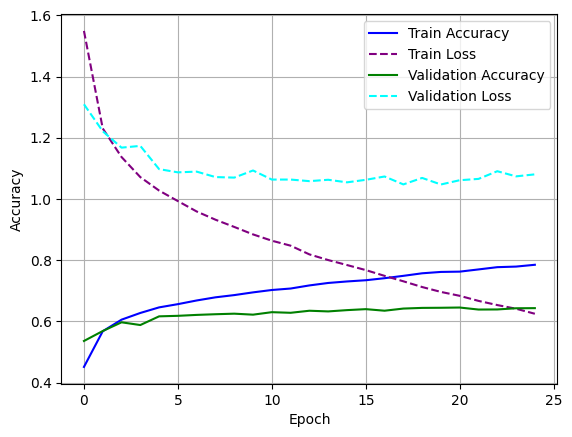

313/313 - 0s - loss: 1.0474 - accuracy: 0.6445 - 298ms/epoch - 952us/step
313/313 [==============================] - 0s 614us/step
Test Accuracy: 0.64
Test Loss: 1.05
Test Precision: 0.65
Test Recall: 0.64
Test F1 Score: 0.64


In [7]:
# Creating the model
model = models.Sequential()

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
# These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Adding Dense/Fully-Connected Layers.
# These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# Fitting the model
fit(model,verbose=0)
del model

##### Comments

* The model in the original notebook has 3 Convolutional Layers, while the model in this question has only 1 Convolutional Layer, thus the model in the original notebook is more complex and will take longer to train.
* This model has a lower accuracy than the original model, this is because the model in the original notebook has more layers and thus can learn more complex features. Similarly, the same can said about the Precision, Recall and F1-Score metrics.
* The model in the original notebook has a lower loss than the model in this question, this is because the model in the original notebook has more layers and thus can learn more complex features.
* From the training and validation accuracy and loss curves, it was noted that the model in the original notebook has a higher training accuracy and a lower training loss than the model in this question.

### Q.2
The original CNN architecture used 32,64,64 output channels for each of the Convolution Layers respectively. Does increasing the output channels (eg. 128,256,256) boost performance on our small dataset? What happens when you decrease the output channels (eg. 8,16,16)?

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 256)         590080    
                                                                 
 flatten_3 (Flatten)         (None, 4096)             

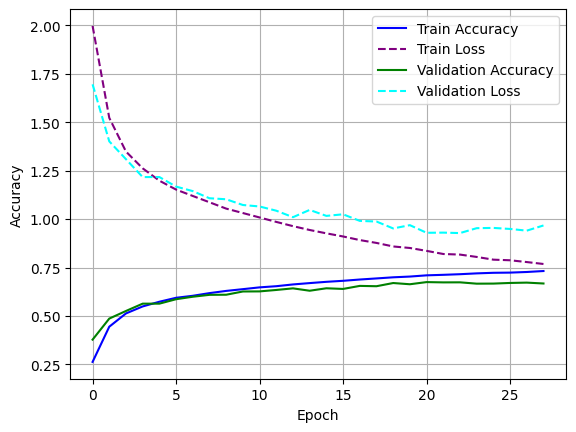

313/313 - 0s - loss: 0.9280 - accuracy: 0.6736 - 436ms/epoch - 1ms/step
313/313 [==============================] - 0s 884us/step
Test Accuracy: 0.67
Test Loss: 0.93
Test Precision: 0.67
Test Recall: 0.67
Test F1 Score: 0.67


In [8]:
# Creating the model
model = models.Sequential()

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
# These extract the most important visual features from the image.
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))

# Adding Dense/Fully-Connected Layers.
# These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

fit(model,verbose=0)

del model


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 8)         224       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 8)        0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 16)        1168      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 16)          2320      
                                                                 
 flatten_4 (Flatten)         (None, 256)              

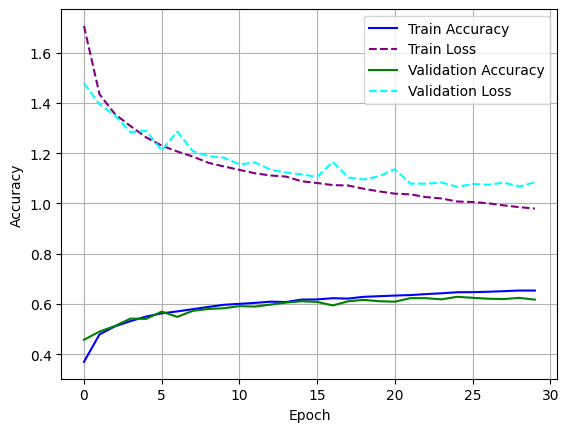

313/313 - 0s - loss: 1.0664 - accuracy: 0.6290 - 334ms/epoch - 1ms/step
313/313 [==============================] - 0s 759us/step
Test Accuracy: 0.63
Test Loss: 1.07
Test Precision: 0.62
Test Recall: 0.63
Test F1 Score: 0.62


In [9]:
#Define Model with lower CNN output channels
model = models.Sequential()

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
# These extract the most important visual features from the image.
model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))

# Adding Dense/Fully-Connected Layers.
# These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# Fitting the model
fit(model,verbose=0)
del model

##### Comments

* Increasing the output channels to 128,256,256 boosted the performance of the model, this is because the model can learn more complex features.
* Decreasing the output channels to 8,16,16 decreased the performance of the model, this is because the model cannot learn complex features.
* The model with 128,256,256 output channels has a higher accuracy, precision, recall and F1-Score than the model with 8,16,16 output channels, whilst respectively incurring a lower loss.

### Q.3
The Convolution Layers apply the _convolution_ operation on the image. Max-Pooling slides (in this case) a <code>2x2</code> window across the resulting convolution and takes only the maximum value. Max-Pooling adds translation invariance to the model - meaning translating the image by a small amount does not significnatly hinder performance.

Max-Pooling also helps reduce the size of the visual features, but having too large of a window might ignore more finer details of the object in the image. Show this empirically, by increasing the size of the <code>MaxPooling2D</code> sliding window and noting any changes in performance and time-efficiency. By looking at the original model's summary, we can see that the final <code>Conv2D</code> layer was outputting features in <code>4x4</code> matrices. Try and make the third <code>Conv2D</code> layer output <code>1x1</code> matrices of features instead, by editing some parameters of the <code>MaxPooling2D</code> layers.



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 flatten_5 (Flatten)         (None, 7744)             

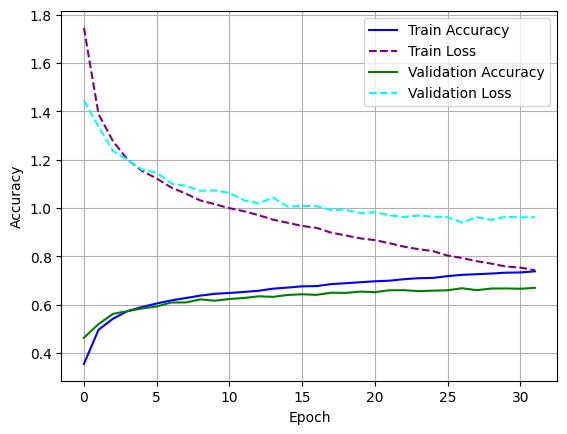

313/313 - 0s - loss: 0.9403 - accuracy: 0.6682 - 348ms/epoch - 1ms/step
313/313 [==============================] - 0s 833us/step
Test Accuracy: 0.67
Test Loss: 0.94
Test Precision: 0.67
Test Recall: 0.67
Test F1 Score: 0.67


In [10]:
#Define Model with bigger MaxPooling Window.
model = models.Sequential()

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
# These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((1, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Adding Dense/Fully-Connected Layers.
# These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# Fitting the model
fit(model,verbose=0)
del model

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 3, 4, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 1, 2, 64)          36928     
                                                                 
 flatten_7 (Flatten)         (None, 128)              

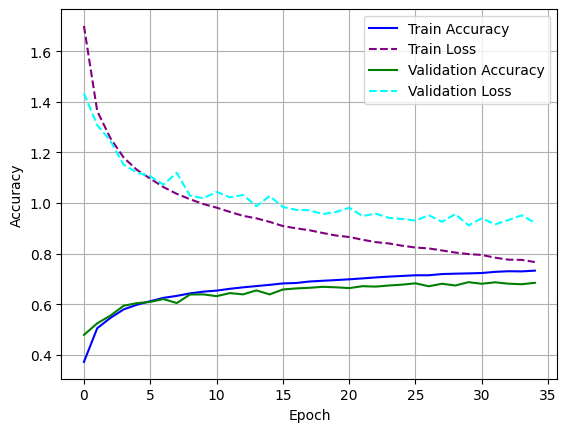

313/313 - 0s - loss: 0.9115 - accuracy: 0.6868 - 374ms/epoch - 1ms/step
313/313 [==============================] - 0s 834us/step
Test Accuracy: 0.69
Test Loss: 0.91
Test Precision: 0.69
Test Recall: 0.69
Test F1 Score: 0.69


In [12]:
#Define Model with bigger MaxPooling Window.
model = models.Sequential()

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
# These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((4, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Adding Dense/Fully-Connected Layers.
# These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# Fitting the model
fit(model,verbose=0)
del model

##### Comments

* Decreasing the size of the MaxPooling2D sliding window to 1x1 decreased the performance of the model, this is because the model is underfitting and cannot learn complex features.
* On the other hand, increasing the size of the MaxPooling2D sliding window to 4x3 presented better results then the 1x1 sliding window, but not as good as the original 2x2 sliding window. This is because the model can learn more complex features, but at the same time, it is ignoring finer details of the object in the image.
* Additionally, when the size of the kernel is increased, the training time is decreased, as there would be less iterations to perform.

### Q.4
Activation Functions are applied to the output of a neuron in a Neural Network. ReLU (Rectified Linear Unit) is one of the most popular activation functions used in Machine Learning. Experiment with another activation function of your choice and note any differences.

Testing relu activation function
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_34 (Flatten

None
Training Time: 44.19s
**************************************************


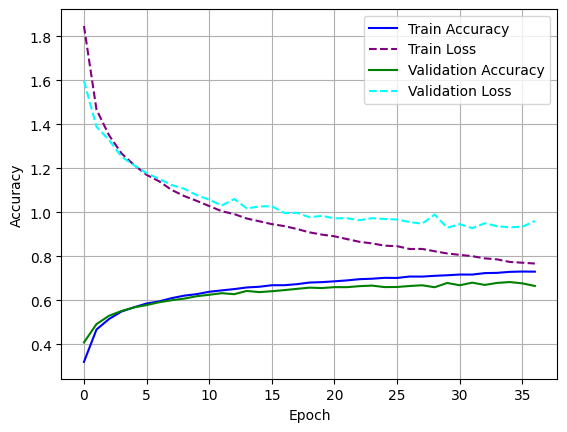

313/313 - 0s - loss: 0.9281 - accuracy: 0.6805 - 381ms/epoch - 1ms/step
313/313 [==============================] - 0s 865us/step
Test Accuracy: 0.68
Test Loss: 0.93
Test Precision: 0.68
Test Recall: 0.68
Test F1 Score: 0.68
Testing sigmoid activation function
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                    

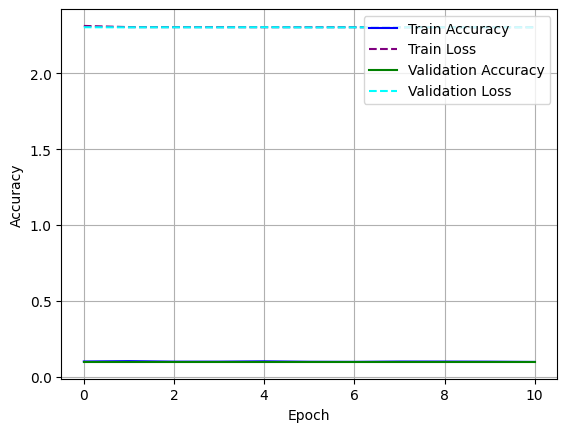

313/313 - 0s - loss: 2.3030 - accuracy: 0.1000 - 406ms/epoch - 1ms/step
313/313 [==============================] - 0s 811us/step
Test Accuracy: 0.1
Test Loss: 2.3
Test Precision: 0.01
Test Recall: 0.1
Test F1 Score: 0.02
Testing softmax activation function
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_75 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                       

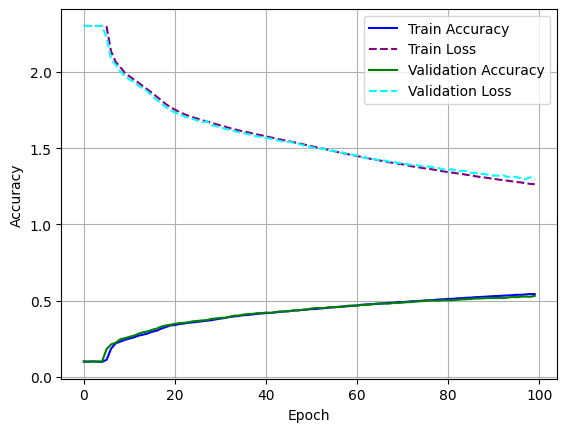

313/313 - 1s - loss: 1.2930 - accuracy: 0.5310 - 788ms/epoch - 3ms/step
313/313 [==============================] - 1s 1ms/step
Test Accuracy: 0.53
Test Loss: 1.29
Test Precision: 0.52
Test Recall: 0.53
Test F1 Score: 0.52
Testing elu activation function
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                          

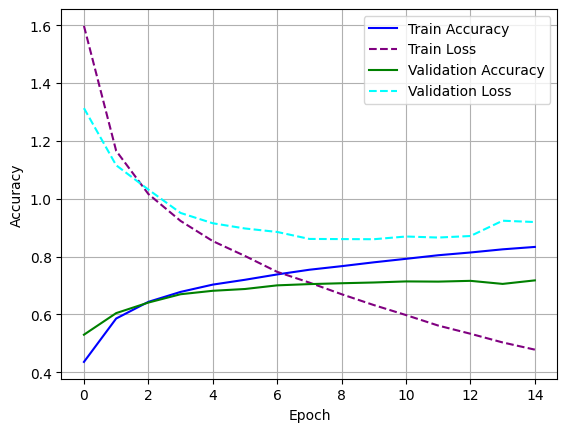

313/313 - 0s - loss: 0.8600 - accuracy: 0.7104 - 354ms/epoch - 1ms/step
313/313 [==============================] - 0s 700us/step
Test Accuracy: 0.71
Test Loss: 0.86
Test Precision: 0.71
Test Recall: 0.71
Test F1 Score: 0.71
Testing selu activation function
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                       

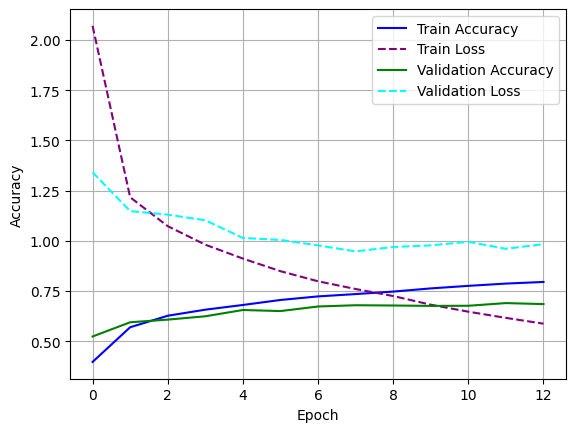

313/313 - 0s - loss: 0.9473 - accuracy: 0.6791 - 352ms/epoch - 1ms/step
313/313 [==============================] - 0s 773us/step
Test Accuracy: 0.68
Test Loss: 0.95
Test Precision: 0.68
Test Recall: 0.68
Test F1 Score: 0.67
Testing tanh activation function
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_83 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_84 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                       

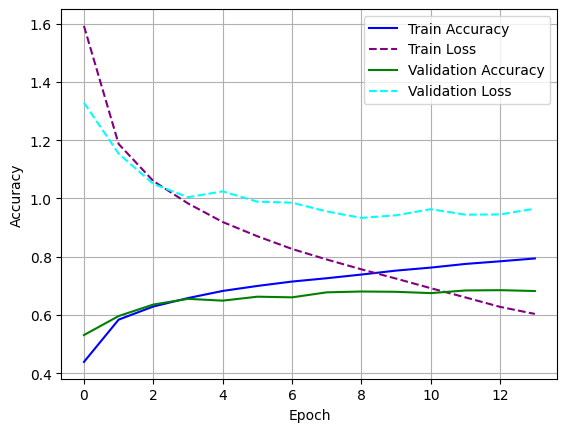

313/313 - 0s - loss: 0.9331 - accuracy: 0.6803 - 336ms/epoch - 1ms/step
313/313 [==============================] - 0s 750us/step
Test Accuracy: 0.68
Test Loss: 0.93
Test Precision: 0.68
Test Recall: 0.68
Test F1 Score: 0.68
Testing hard_sigmoid activation function
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_86 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_87 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                               

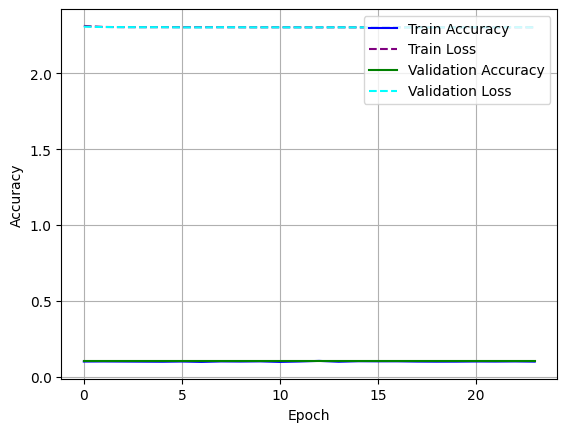

313/313 - 0s - loss: 2.3031 - accuracy: 0.1000 - 365ms/epoch - 1ms/step
313/313 [==============================] - 0s 882us/step
Test Accuracy: 0.1
Test Loss: 2.3
Test Precision: 0.01
Test Recall: 0.1
Test F1 Score: 0.02
Testing softplus activation function
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_89 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_90 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                      

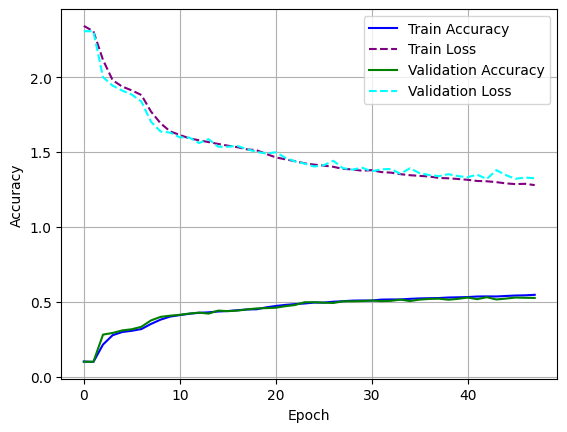

313/313 - 0s - loss: 1.3201 - accuracy: 0.5310 - 339ms/epoch - 1ms/step
313/313 [==============================] - 0s 722us/step
Test Accuracy: 0.53
Test Loss: 1.32
Test Precision: 0.53
Test Recall: 0.53
Test F1 Score: 0.52
Testing softsign activation function
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                   

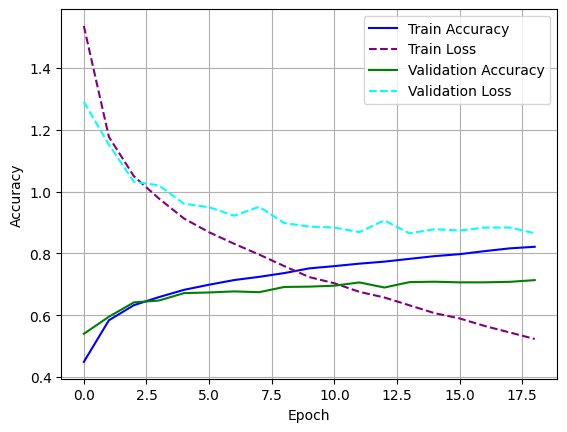

313/313 - 0s - loss: 0.8650 - accuracy: 0.7073 - 353ms/epoch - 1ms/step
313/313 [==============================] - 0s 750us/step
Test Accuracy: 0.71
Test Loss: 0.87
Test Precision: 0.71
Test Recall: 0.71
Test F1 Score: 0.71
Testing swish activation function
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_95 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                      

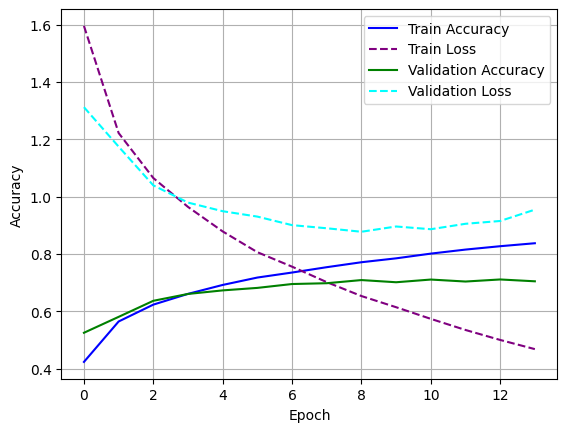

313/313 - 0s - loss: 0.8773 - accuracy: 0.7088 - 395ms/epoch - 1ms/step
313/313 [==============================] - 0s 786us/step
Test Accuracy: 0.71
Test Loss: 0.88
Test Precision: 0.71
Test Recall: 0.71
Test F1 Score: 0.71


In [23]:
# Defining the activation functions to test
activation_functions = ['relu', 'sigmoid', 'softmax', 'elu', 'selu', 'tanh', 'hard_sigmoid', 'softplus', 'softsign', 'swish']
best_activation_function = None
best_activation_function_acc = 0

for activation_function in activation_functions:
  print(f'\033[36mTesting {activation_function} activation function\033[0m')
  # Defining the model
  model = models.Sequential()

  # Performing 2D Convolution + MaxPooling on the image, reducing its size.
  # These extract the most important visual features from the image.
  model.add(layers.Conv2D(32, (3, 3), activation=activation_function, input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation=activation_function))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation=activation_function))

  # Adding Dense/Fully-Connected Layers.
  # These contian the 'classification' part of the model.
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation=activation_function))
  model.add(layers.Dense(10))

  # Fitting the model
  test_acc = fit(model,verbose=0)

  # Saving the best activation function
  if best_activation_function_acc < test_acc:
    best_activation_function_acc = test_acc
    best_activation_function = activation_function
  del model

In [24]:
print(f'\033[36mBest Activation Function: {best_activation_function}\033[0m')

Best Activation Function: elu


##### Comments

* The best models were the ones with  the ELU, SoftSign, ReLU and Tanh activation functions, this is because these activation functions are non-linear and thus can learn complex features.
* On the other hand, the models with the Sigmoid and Softmax activation functions or a variant of them performed poorly, this is because these activation functions are linear and thus cannot learn complex features.
* It was also noted that the SoftSign activation function performed better than the SoftPlus activation function, this is because the SoftSign activation function is non-linear and thus can learn complex features, whilst the SoftPlus activation function is linear and thus cannot learn complex features.

### Q.5
We have explored with improving the feautre detection process. Now let's turn our attention to the _classifier_ part; the final fully-connected layer. After flattening the features into a 1-D vector, can you modify the final dense layer (change number of neurons, add more layers, etc.) and describe how this affects the performance of the model?

Note: The final output of the dense layer must still be 10, as this is the number of classes in our _CIFAR10_ dataset.

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_111 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_112 (Conv2D)         (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_113 (Conv2D)         (None, 4, 4, 64)          36928     


                                                                 
 flatten_49 (Flatten)        (None, 1024)              0         
                                                                 
 dense_103 (Dense)           (None, 32)                32800     
                                                                 
 dense_104 (Dense)           (None, 10)                330       
                                                                 
Total params: 89,450
Trainable params: 89,450
Non-trainable params: 0
_________________________________________________________________
None
Training Time: 47.54s
**************************************************


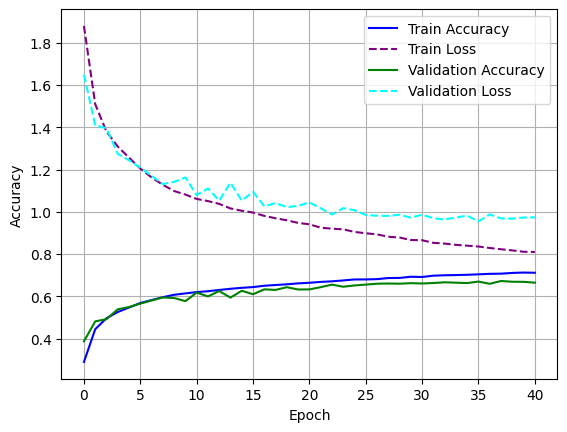

313/313 - 0s - loss: 0.9547 - accuracy: 0.6696 - 410ms/epoch - 1ms/step
313/313 [==============================] - 0s 833us/step
Test Accuracy: 0.67
Test Loss: 0.95
Test Precision: 0.67
Test Recall: 0.67
Test F1 Score: 0.67


In [30]:
# Defining Model with modified dense layers (Reducing the number of neurons)
model = models.Sequential()

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
# These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Adding Dense/Fully-Connected Layers.
# These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10))

# Fitting the model
fit(model,verbose=0)
del model

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_103 (Conv2D)         (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_104 (Conv2D)         (None, 4, 4, 64)          36928     
                                                                 
 flatten_46 (Flatten)        (None, 1024)            

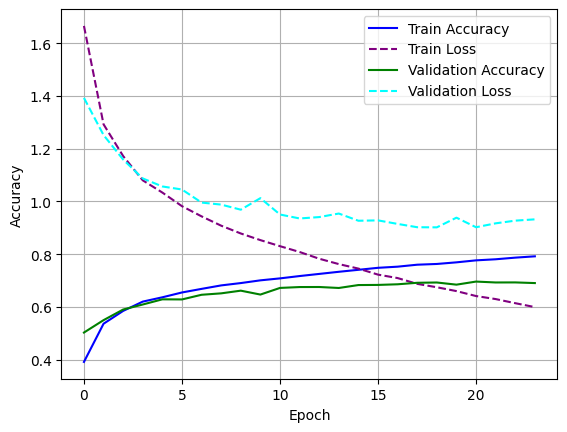

313/313 - 0s - loss: 0.9017 - accuracy: 0.6924 - 335ms/epoch - 1ms/step
313/313 [==============================] - 0s 771us/step
Test Accuracy: 0.69
Test Loss: 0.9
Test Precision: 0.7
Test Recall: 0.69
Test F1 Score: 0.69


In [27]:
#Define Model with modified dense layers (Adding the number of neurons)
model = models.Sequential()

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
# These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Adding Dense/Fully-Connected Layers.
# These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10))

# Fitting the model
fit(model,verbose=0)
del model

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_114 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_115 (Conv2D)         (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_116 (Conv2D)         (None, 4, 4, 64)          36928     
                                                                 
 flatten_50 (Flatten)        (None, 1024)            

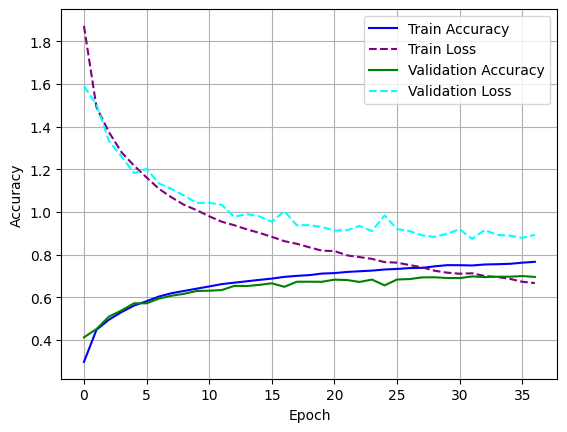

313/313 - 0s - loss: 0.8742 - accuracy: 0.6984 - 378ms/epoch - 1ms/step
313/313 [==============================] - 0s 844us/step
Test Accuracy: 0.7
Test Loss: 0.87
Test Precision: 0.7
Test Recall: 0.7
Test F1 Score: 0.7


In [31]:
# Defining Model with modified dense layers (Adding extra layers)
model = models.Sequential()

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
# These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Adding Dense/Fully-Connected Layers.
# These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(10))

# Fitting the model
fit(model,verbose=0)
del model

##### Comments

* The best model was the one with 3 Dense Layers, this is because the model can learn more complex features.
* The model with 3 Dense Layers has a higher accuracy, precision, recall and F1-Score than the model with 1 Dense Layer, whilst respectively incurring a lower loss.
* Increasing the number of neurons in the Dense Layer from 64 to 128, reduced the performance of the model, this is because the model is overfitting.
* Decreasing the number of neurons in the Dense Layer from 64 to 32, decreased the performance of the model, ensuring that the model is not overfitting.

### Q.6
In a Neural Network, the optimizer is the heuristic function used to 'push' the model down the right path. Compare two versions of an architecture of your choice that use different optimizers. This can be done by setting the <code>optimizer</code> parameter in the <code>fit</code> function (eg. <code>optimizer='sgd'</code>).

Testing <keras.optimizers.optimizer_v2.gradient_descent.SGD object at 0x000001E7EB22E5B0> optimizer
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_117 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_51 (Flatten)        (None, 7200)              0         
                                                                 
 dense_109 (Dense)           (None, 64)                460864    
                                                                 
 dense_110 (Dense)           (None, 10)                650       
                                                                 
Total params: 462,4

None
Training Time: 60.43s
**************************************************


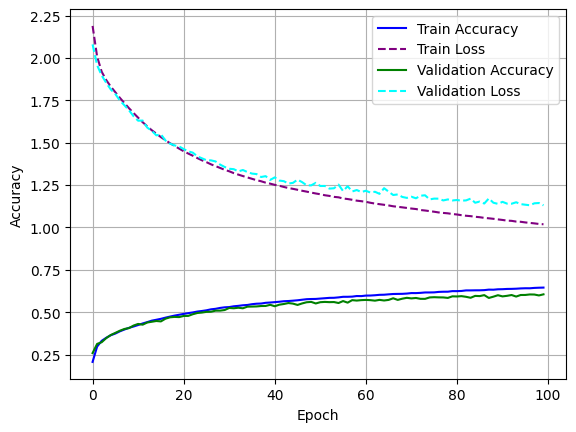

313/313 - 0s - loss: 1.1301 - accuracy: 0.6051 - 305ms/epoch - 975us/step
313/313 [==============================] - 0s 655us/step
Test Accuracy: 0.61
Test Loss: 1.13
Test Precision: 0.6
Test Recall: 0.61
Test F1 Score: 0.6
Testing <keras.optimizers.optimizer_v2.rmsprop.RMSprop object at 0x000001E7EB22E040> optimizer
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_118 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_52 (Flatten)        (None, 7200)              0         
                                                                 
 dense_111 (Dense)           (None, 64)                460864   

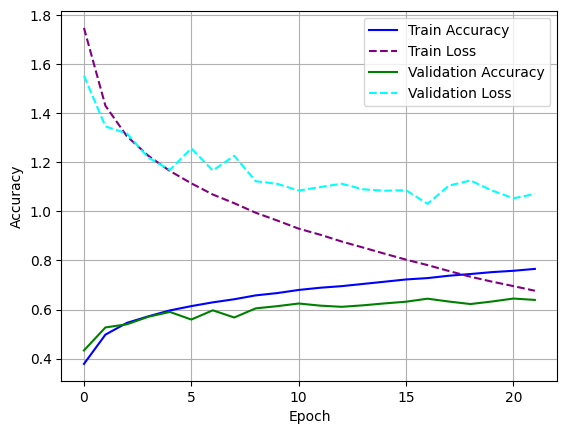

313/313 - 0s - loss: 1.0309 - accuracy: 0.6442 - 302ms/epoch - 966us/step
313/313 [==============================] - 0s 635us/step
Test Accuracy: 0.64
Test Loss: 1.03
Test Precision: 0.65
Test Recall: 0.64
Test F1 Score: 0.64
Testing <keras.optimizers.optimizer_v2.adagrad.Adagrad object at 0x000001E7EB22EBB0> optimizer
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_119 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_86 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_53 (Flatten)        (None, 7200)              0         
                                                                 
 dense_113 (Dense)           (None, 64)                460864 

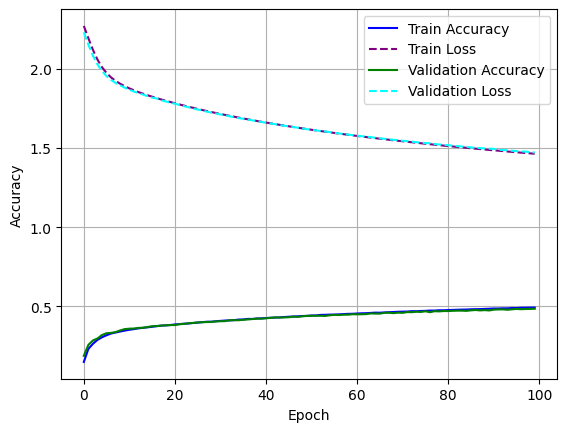

313/313 - 0s - loss: 1.4720 - accuracy: 0.4850 - 309ms/epoch - 988us/step
313/313 [==============================] - 0s 664us/step
Test Accuracy: 0.49
Test Loss: 1.47
Test Precision: 0.48
Test Recall: 0.48
Test F1 Score: 0.48
Testing <keras.optimizers.optimizer_v2.adadelta.Adadelta object at 0x000001E4B6F1C4C0> optimizer
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_54 (Flatten)        (None, 7200)              0         
                                                                 
 dense_115 (Dense)           (None, 64)                46086

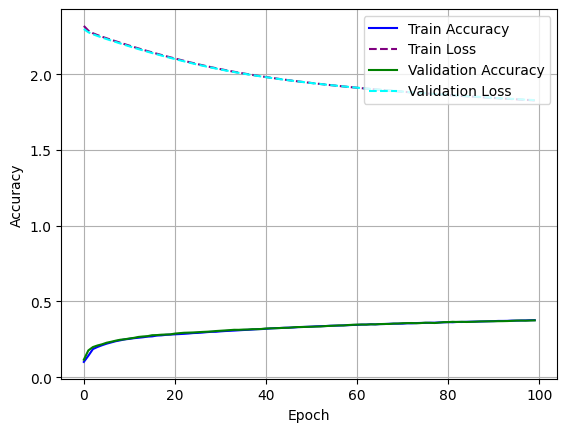

313/313 - 0s - loss: 1.8289 - accuracy: 0.3752 - 318ms/epoch - 1ms/step
313/313 [==============================] - 0s 703us/step
Test Accuracy: 0.38
Test Loss: 1.83
Test Precision: 0.37
Test Recall: 0.38
Test F1 Score: 0.36
Testing <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001E4B6F1C640> optimizer
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_121 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_55 (Flatten)        (None, 7200)              0         
                                                                 
 dense_117 (Dense)           (None, 64)                460864    
    

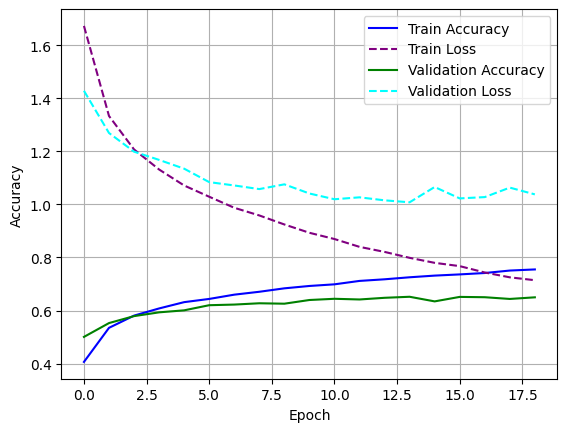

313/313 - 0s - loss: 1.0079 - accuracy: 0.6520 - 316ms/epoch - 1ms/step
313/313 [==============================] - 0s 674us/step
Test Accuracy: 0.65
Test Loss: 1.01
Test Precision: 0.65
Test Recall: 0.65
Test F1 Score: 0.65
Testing <keras.optimizers.optimizer_v2.adamax.Adamax object at 0x000001E4B6F1C5B0> optimizer
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_122 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_89 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_56 (Flatten)        (None, 7200)              0         
                                                                 
 dense_119 (Dense)           (None, 64)                460864    


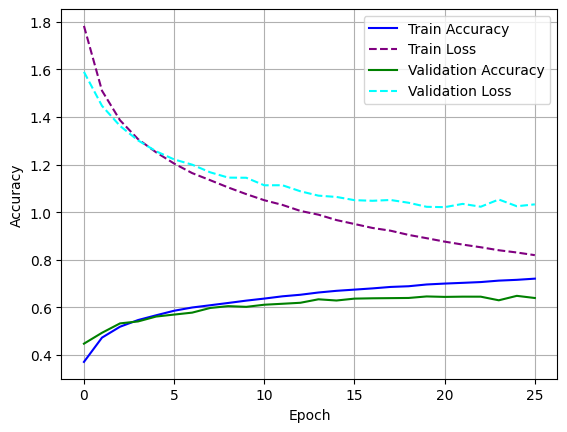

313/313 - 0s - loss: 1.0212 - accuracy: 0.6442 - 306ms/epoch - 979us/step
313/313 [==============================] - 0s 641us/step
Test Accuracy: 0.64
Test Loss: 1.02
Test Precision: 0.64
Test Recall: 0.64
Test F1 Score: 0.64
Testing <keras.optimizers.optimizer_v2.nadam.Nadam object at 0x000001E4B6F1CFA0> optimizer
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_123 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_90 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_57 (Flatten)        (None, 7200)              0         
                                                                 
 dense_121 (Dense)           (None, 64)                460864    


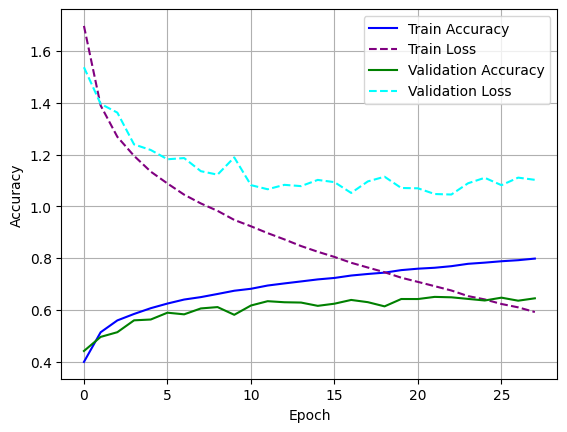

313/313 - 0s - loss: 1.0456 - accuracy: 0.6484 - 331ms/epoch - 1ms/step
313/313 [==============================] - 0s 673us/step
Test Accuracy: 0.65
Test Loss: 1.05
Test Precision: 0.65
Test Recall: 0.65
Test F1 Score: 0.65


In [32]:
# Defining Model with modified dense layers (Adding extra layers)
optimizers = [SGD(clipnorm=1.0), RMSprop(clipnorm=1.0), Adagrad(clipnorm=1.0), Adadelta(clipnorm=1.0), Adam(clipnorm=1.0), Adamax(clipnorm=1.0), Nadam(clipnorm=1.0)]
best_optimizer = None
best_optimizer_acc = 0

for optimizer in optimizers:
  print(f'\033[36mTesting {optimizer} optimizer\033[0m')
  # Defining the model
  model = models.Sequential()

  # Performing 2D Convolution + MaxPooling on the image, reducing its size.
  # These extract the most important visual features from the image.
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  # Adding Dense/Fully-Connected Layers.
  # These contian the 'classification' part of the model.
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(10))

  # Fitting the model
  test_acc = fit(model,verbose=0, optimizer=optimizer)

  # Saving the best optimizer
  if best_optimizer_acc < test_acc:
    best_optimizer_acc = test_acc
    best_optimizer = optimizer
    
  del model

In [33]:
print(f'\033[36mBest Optimizer: {best_optimizer}\033[0m')

Best Optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001E4B6F1C640>


##### Comments

* The best model was the one with the Adam optimizer, this is because the Adam optimizer is an adaptive learning rate optimization algorithm that's been designed specifically for training deep neural networks.
* The model with the Adam optimizer has a higher accuracy, precision, recall and F1-Score than the model with the SGD optimizer, whilst respectively incurring a lower loss.
* The model with the AdaGrad and AdaDelta optimizers performed the worst, this is because the AdaGrad and AdaDelta optimizers are adaptive learning rate optimization algorithms that have been designed specifically for training deep neural networks, but are not as good as the Adam optimizer in terms of CNNs.
* Surprisingly, the model with SGD optimizer performed better than the model with the AdaGrad and AdaDelta optimizers, this is because the SGD optimizer is a stochastic gradient descent optimizer that is not adaptive and thus was not overfitting in this case.

### Q.7
The original CNN architecture managed to achieve ~70% accuracy on the test set using 122,570 model parameters. Can you define your own CNN architecture and try to improve on the original model? Improvements include: achieving higher performance on the test set, comparable performance using significantly fewer model parameters, faster training time, different model architecture, etc...

Note down which factors of your CNN architecture you found to be the most responsible for contributing to model performance.

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_157 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_242 (Ba  (None, 30, 30, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_158 (Conv2D)         (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_243 (Ba  (None, 28, 28, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                     

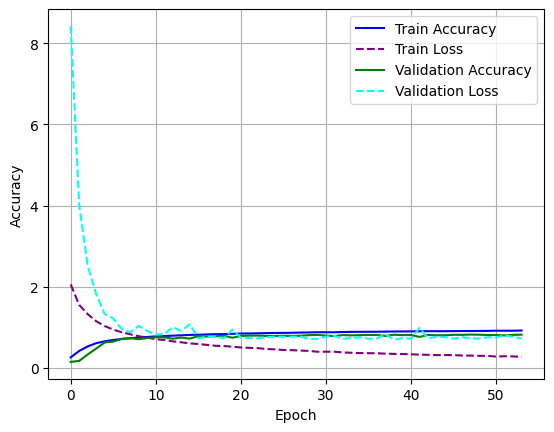

313/313 - 1s - loss: 0.6929 - accuracy: 0.8155 - 595ms/epoch - 2ms/step
313/313 [==============================] - 1s 1ms/step
Test Accuracy: 0.82
Test Loss: 0.69
Test Precision: 0.81
Test Recall: 0.82
Test F1 Score: 0.81


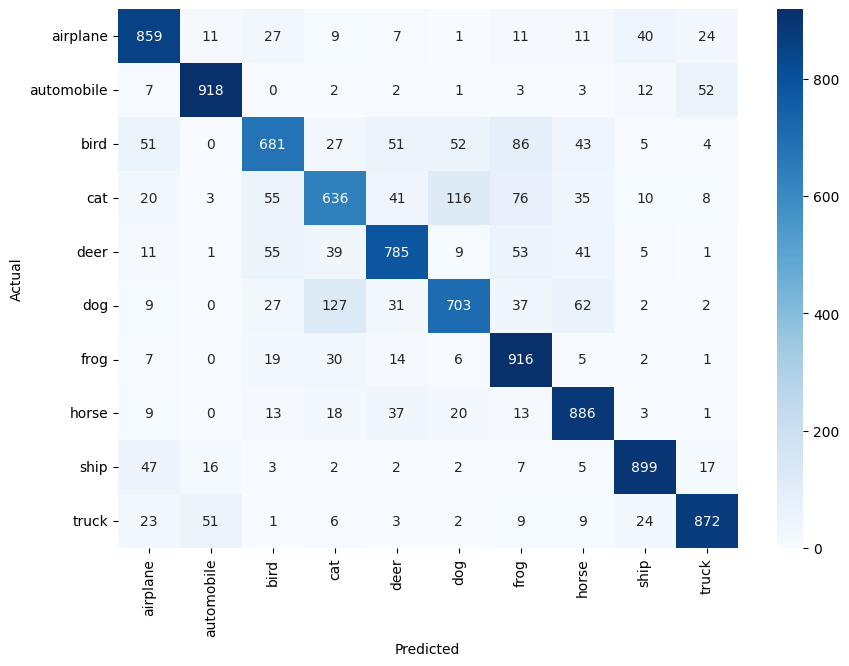

In [31]:
# Defining Custom CNN Model
model = models.Sequential()

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
# These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='elu', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.Conv2D(32, (3, 3), activation='elu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # Adding Dropout for regularization

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
model.add(layers.Conv2D(64, (3, 3), activation='elu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.Conv2D(64, (3, 3), activation='elu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # Adding Dropout for regularization

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
model.add(layers.Conv2D(128, (3, 3), activation='elu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.Conv2D(128, (3, 3), activation='elu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.Dropout(0.25)) # Adding Dropout for regularization

# Adding Dense/Fully-Connected Layers.
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.Dropout(0.5)) # Adding Dropout for regularization

# Adding Dense/Fully-Connected Layers.
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.Dropout(0.5)) # Adding Dropout for regularization

# Adding Dense/Fully-Connected Layers.
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.Dropout(0.5)) # Adding Dropout for regularization

# Adding Dense/Fully-Connected Layers.
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.Dropout(0.5)) # Adding Dropout for regularization

# Final Dense Layer (Output Layer having 10 neurons for 10 classes)
model.add(layers.Dense(10))

# Adding Softmax Activation to the output layer
model.add(layers.Activation('softmax'))

# Fitting the model
fit(model,verbose=0, epochs=1000, optimizer=Adam(clipnorm=3.0, learning_rate=0.007), batch_size=512, callbacks=EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True), colors=('blue','purple','green','cyan'), do_display=True, do_save=True, save_name='model')
del model

##### Comments

* The above architecture managed to achieve an improved `Accuracy`, `Precision`, `Recall` and `F1-Score` of 82% on the test set using 531,818 model parameters.
* Moreover, the `Precision`, `Recall` and `F1-Score` metrics were also improved, whilst incurring a lower `Loss`.
* To facilitate best results the following factors were considered:
    1. Utilised an `increasing the number of Convolutional Layers`, to ensure that the model can learn complex features.
    2. Utilised a `large number of neurons and layers in the Dense Layer`, to ensure that the model can learn complex features.
    3. Added the `softmax activation function` to the final Dense Layer, to ensure that the model would not overfit.
    4. Utilised the `Adam optimizer` with `gradient clipping` and an `appropriate learning rate`, to ensure that the model would not overfit.
    5. Utilised the `ELU` and `ReLU` activation functions as they were the best performing activation functions, to ensure that the model would not overfit.
    6. Utilised an `Early Stopping callback`, to ensure that the model would not overfit.
    7. Utilised several `Dropout layers`, to curb overfitting.
    8. Utilised several `Batch Normalization layers`, to ensure that the model would not overfit.
    9. Utilised a `large batch size`, to ensure that the model would not overfit.
    10. Utilised a `large number of epochs`, to ensure that the model would not overfit.
* From the above `training and validation accuracy and loss curves`, it can be noted that the model is not overfitting, as the curves are gradually converging.
* From the above `confusion matrix`, it was noted that the model is generally performing well, however, it is struggling to classify the `cat` and `dog` classes correctly.
* From the above `distinct diagonal line` in the `confusion matrix`, it was noted that the model is performing well, as the model is correctly classifying the majority of the classes.